# This notebook for running a centralized version of the source seeking algorithm

In [3]:

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pickle as pkl
import networkx as nx
from matplotlib import style
from functools import partial

from utils.dLdp import analytic_dLdp,analytic_dhdz,analytic_dhdq,analytic_FIM
from utils.CentralizedEKF import CentralizedEKF

import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def single_meas_func(C1,C0,k,b,dist):
    return k*(dist-C1)**b+C0

def joint_meas_func(C1s,C0s,ks,bs,x,ps):

    # Casting for the compatibility of jax.numpy

    C1=np.array(C1s)
    C0=np.array(C0s)
    k=np.array(ks)
    b=np.array(bs)
    p=np.array(ps)

    # Keep in mind that x is a vector of [q,q'], thus only the first half of components are observable.    
    dists=np.linalg.norm(x[:len(x)//2]-p,axis=1)

    return single_meas_func(C1,C0,k,b,dists) 

In [152]:
q = np.array([6,6])
  
def main(N_trails,N_sen):
    '''Experiment Parameters'''
  
    N_iter=80
    C_gain=0.1

    # Set up virtual sensors
    C1=-0.3 # Setting C1 as a negative number mitigates the blowing-up effect when the sensors are close to the source.
    C0=0
    k=1
    b=-2
    noise_std = 0.01
    minimum_sensing_reading=1e-5

    # The step size of each sensor
    max_linear_speed=0.1

    # Terminal condition
    contact_radius = 0.1


    t=time.time()
    data={'p':[],'qhat':[]}

    for _ in range(N_trails):

        '''Initialize Key Data Structures'''
        p_0 = np.random.rand(N_sen,2)*3
        qhat_0 = np.array([3,4])
        
        p = np.array(p_0) # Sensor Positins
        qhat = np.array(qhat_0)

        # The Centralized EKF
        estimator = CentralizedEKF(qhat_0)

        C1s=C1*np.ones(N_sen)
        C0s = C0*np.ones(N_sen)
        ks = k * np.ones(N_sen)
        bs = b*np.ones(N_sen)

        h=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes h(z,ps))
        dhdz=partial(analytic_dhdz,C1s=C1s,C0s=C0s,ks=ks,bs=bs)
        dhdqs=partial(analytic_dhdq,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

        '''Main Loop'''

        p_history = []
        qhat_history = []
        for _ in range(N_iter):
#             if np.min(np.linalg.norm(p-q,axis=1))>contact_radius:#Move and estimate only when not touching the source.
            # Measure
            r = np.linalg.norm(q-p,axis=1)
            y = k* ((r-C1)**b)+C0 + np.random.randn(N_sen)*noise_std
            y[y<=0]=minimum_sensing_reading # We don't want y to be zero or negative.


            # Estimate

            qhat=estimator.update_and_estimate_loc(h,dhdz,y,p)

            # Gradient update

            dp=analytic_dLdp(qhat,p,C1,C0,k,b)
            p-=max_linear_speed*(dp.T/np.linalg.norm(dp,axis=1)).T

            # Record data
            p_history.append(np.array(p))
            qhat_history.append(np.array(qhat))  

            # Check terminal condition
            
        data['p'].append(np.array(p_history))
        data['qhat'].append(np.array(qhat_history))

    print('Time:',time.time()-t)
    return data

In [153]:
N_trails = 100
n_sen=6
data={}
data['centralized'] = main(N_trails,n_sen)

Time: 1.7120914459228516


In [154]:
filepath = "CentralizedData-6Sensor.pkl"
with open(filepath,'wb') as file:
    pkl.dump(data,file)


(100, 80, 2) (100, 80, 6)


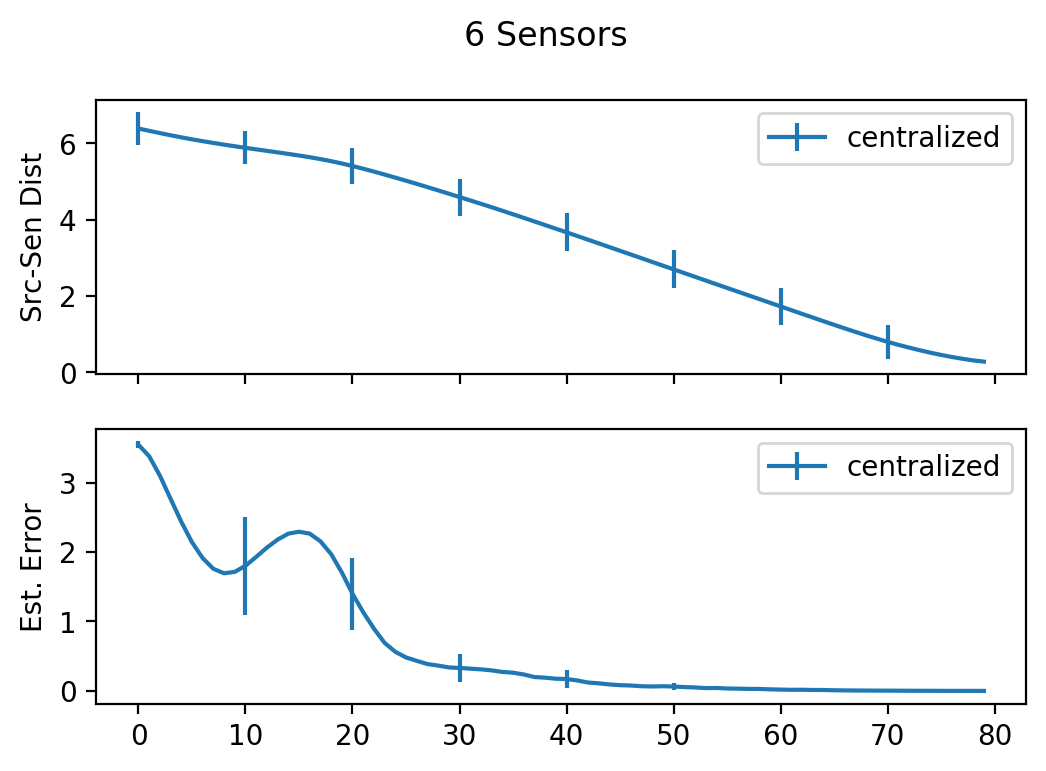

In [155]:
'''Plotting'''
q = np.array([6,6])
filepath = "CentralizedData-6Sensor.pkl"
with open(filepath,'rb') as file:
    data=pkl.load(file)
fig,axes=plt.subplots(2,dpi=200,sharex=True)
for name,d in data.items():
    ps = np.array(d['p'])
    qhat = np.array(d['qhat'])
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q,axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
#     axes[0].plot(x,ave_median_dist,label= name)
#     axes[0].fill_between(x,ave_median_dist+std_median_dist,ave_median_dist-std_median_dist,alpha=0.2)

    axes[0].errorbar(x,ave_median_dist,yerr=std_median_dist,label= name,errorevery=10)
    axes[0].set_ylabel('Src-Sen Dist')
    axes[0].legend()
    

    err = np.linalg.norm(qhat-q,axis=-1)
    ave_median_err = np.mean(err,axis=0)
    std_median_err = np.std(err,axis=0)
    x = np.arange(N_iter)
#     axes[1].plot(x,ave_median_err,label= name)
#     axes[1].fill_between(x,ave_median_err+std_median_err,ave_median_err-std_median_err,alpha=0.2)
    axes[1].errorbar(x,ave_median_err,yerr=std_median_err,label= name,errorevery=10)
    axes[1].set_ylabel('Est. Error')
    axes[1].legend()
fig.suptitle('6 Sensors')
# fig.tight_layout()
plt.show()

In [156]:
N_trails = 100
n_sen=20
data={}
data['centralized'] = main(N_trails,n_sen)

Time: 1.9894325733184814


In [157]:
filepath = "CentralizedData-20Sensor.pkl"
with open(filepath,'wb') as file:
    pkl.dump(data,file)


(100, 80, 2) (100, 80, 20)


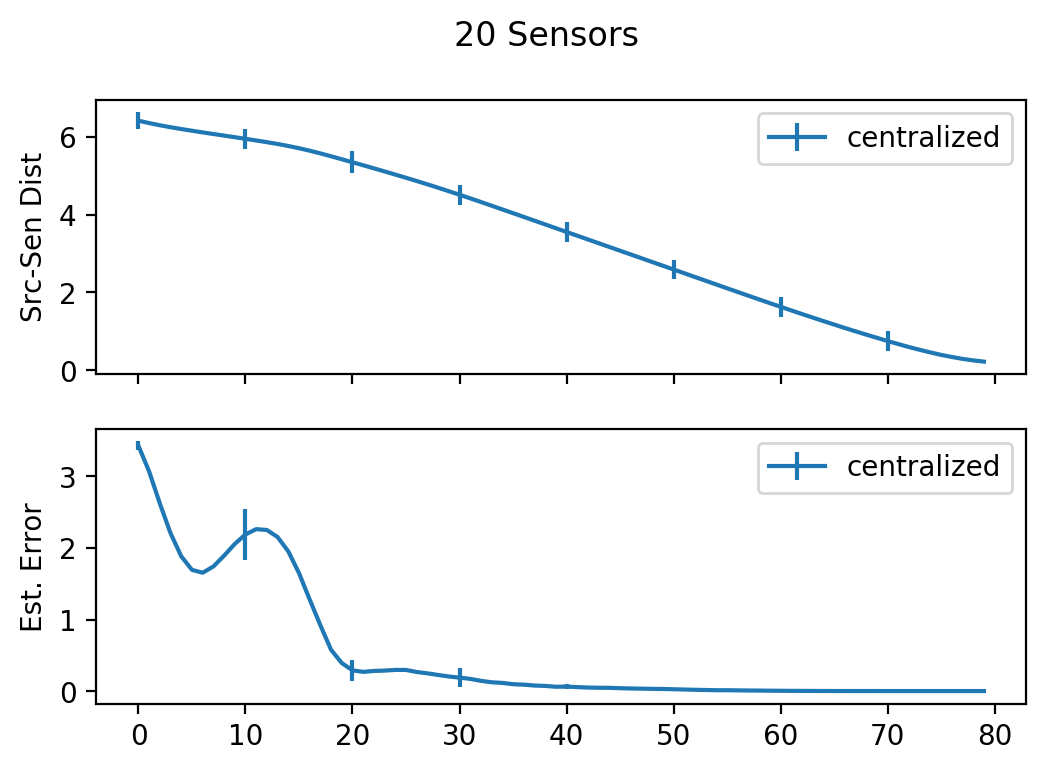

In [158]:
'''Plotting'''
q = np.array([6,6])
filepath = "CentralizedData-20Sensor.pkl"
with open(filepath,'rb') as file:
    data=pkl.load(file)
fig,axes=plt.subplots(2,dpi=200,sharex=True)
for name,d in data.items():
    ps = np.array(d['p'])
    qhat = np.array(d['qhat'])
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q,axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
#     axes[0].plot(x,ave_median_dist,label= name)
#     axes[0].fill_between(x,ave_median_dist+std_median_dist,ave_median_dist-std_median_dist,alpha=0.2)

    axes[0].errorbar(x,ave_median_dist,yerr=std_median_dist,label= name,errorevery=10)
    axes[0].set_ylabel('Src-Sen Dist')
    axes[0].legend()
    

    err = np.linalg.norm(qhat-q,axis=-1)
    ave_median_err = np.mean(err,axis=0)
    std_median_err = np.std(err,axis=0)
    x = np.arange(N_iter)
#     axes[1].plot(x,ave_median_err,label= name)
#     axes[1].fill_between(x,ave_median_err+std_median_err,ave_median_err-std_median_err,alpha=0.2)
    axes[1].errorbar(x,ave_median_err,yerr=std_median_err,label= name,errorevery=10)
    axes[1].set_ylabel('Est. Error')
    axes[1].legend()
fig.suptitle('20 Sensors')
# fig.tight_layout()
plt.show()

In [159]:
N_trails = 100
n_sen=50
data={}
data['centralized'] = main(N_trails,n_sen)

Time: 3.497375965118408


In [160]:
filepath = "CentralizedData-50Sensor.pkl"
with open(filepath,'wb') as file:
    pkl.dump(data,file)


(100, 80, 2) (100, 80, 50)


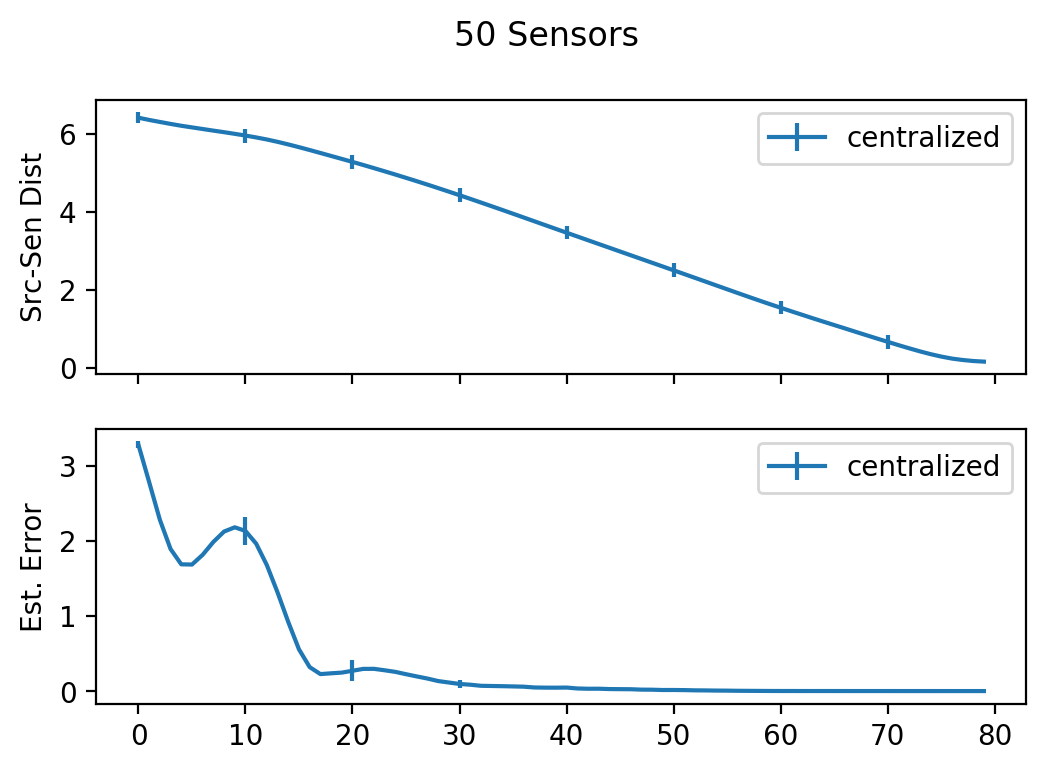

In [161]:
'''Plotting'''
q = np.array([6,6])
filepath = "CentralizedData-50Sensor.pkl"
with open(filepath,'rb') as file:
    data=pkl.load(file)
fig,axes=plt.subplots(2,dpi=200,sharex=True)
for name,d in data.items():
    ps = np.array(d['p'])
    qhat = np.array(d['qhat'])
     # qhat.shape=ps.shape=(N_trails,N_iter,space_dim)
    dist = np.linalg.norm(ps-q,axis=-1)
    # dist.shape = (N_trails,N_iter,N_sen)
    print(qhat.shape,dist.shape)
 
    
    ave_median_dist = np.mean(np.median(dist,axis=-1),axis=0)
    std_median_dist = np.std(np.median(dist,axis=-1),axis=0)
    N_iter=len(ave_median_dist)

    x = np.arange(N_iter)
#     axes[0].plot(x,ave_median_dist,label= name)
#     axes[0].fill_between(x,ave_median_dist+std_median_dist,ave_median_dist-std_median_dist,alpha=0.2)

    axes[0].errorbar(x,ave_median_dist,yerr=std_median_dist,label= name,errorevery=10)
    axes[0].set_ylabel('Src-Sen Dist')
    axes[0].legend()
    

    err = np.linalg.norm(qhat-q,axis=-1)
    ave_median_err = np.mean(err,axis=0)
    std_median_err = np.std(err,axis=0)
    x = np.arange(N_iter)
#     axes[1].plot(x,ave_median_err,label= name)
#     axes[1].fill_between(x,ave_median_err+std_median_err,ave_median_err-std_median_err,alpha=0.2)
    axes[1].errorbar(x,ave_median_err,yerr=std_median_err,label= name,errorevery=10)
    axes[1].set_ylabel('Est. Error')
    axes[1].legend()
fig.suptitle('50 Sensors')
# fig.tight_layout()
plt.show()